In [ ]:
%pip install scikit-learn
%pip install scikit-image
%pip install seaborn

  Using cached joblib-1.5.1-py3-none-any.whl.metadata (5.6 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
   ---------------------------------------- 0.0/11.1 MB ? eta -:--:--
    --------------------------------------- 0.3/11.1 MB ? eta -:--:--
   - -------------------------------------- 0.5/11.1 MB 2.1 MB/s eta 0:00:06
   - -------------------------------------- 0.5/11.1 MB 2.1 MB/s eta 0:00:06
   -- ------------------------------------- 0.8/11.1 MB 819.2 kB/s eta 0:00:13
   --- ------------------------------------ 1.0/11.1 MB 1.0 MB/s eta 0:00:10
   ---- ----------------------------------- 1.3/11.1 MB 959.4 kB/s eta 0:00:11
   ---- ----------------------------------- 1.3/11.1 MB 959.4 kB/s eta 0:00:11
   ----- ---------------------------------- 1.6/11.1 MB 892.9 kB/s eta 0:00:11
   ----- ---------------------------------- 1.6/11.1 MB 892.9 kB/s eta 0:00:11
   ------ --------------------------------- 1.8/11.1 MB 860.4 kB/s eta 0:00:11
   ------- ------------

In [65]:
# Import library yang kalian butuhkan
import os
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report
from skimage.feature import graycomatrix, graycoprops
from scipy.stats import entropy
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay)
import seaborn as sns
from collections import Counter

## Data Loading

Buat struktur folder dataset sebagai berikut:
```
.
└──dataset
    ├── label1
	├── image1.jpg
	├── image2.jpg
	└── image3.jpg
    ├── label2
    └── label3
    └── dst...
```

In [ ]:
data = []
labels = []
file_name = []
for sub_folder in os.listdir("dataset\\"):
    sub_folder_files = os.listdir(os.path.join("dataset\\", sub_folder))
    for i, filename in enumerate(sub_folder_files):
        img_path = os.path.join("dataset\\", sub_folder, filename)
        img = cv.imread(img_path)
        img = img.astype(np.uint8)
        img = cv.resize(img, (1400, 700))
        img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        
        data.append(img)
        labels.append(sub_folder)
        name = os.path.splitext(filename)[0]
        file_name.append(filename)
        
data = np.array(data)
labels = np.array(labels)

## Data Understanding

In [66]:
# Jumlah Data
print("Jumlah total gambar:", len(data))
print("Jumlah kelas:", len(np.unique(labels)))
print("Distribusi per kelas:", Counter(labels))

Jumlah total gambar: 333
Jumlah kelas: 3
Distribusi per kelas: Counter({np.str_('Healthy Teeth'): 223, np.str_('Impacted teeth'): 87, np.str_('Infection'): 23})


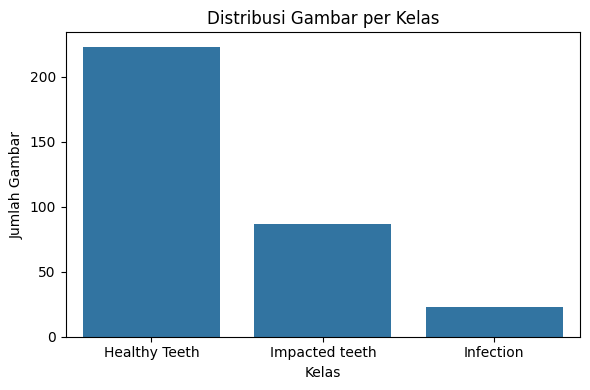

In [67]:
# Distribusi Data
label_df = pd.DataFrame({'Label': labels})
plt.figure(figsize=(6,4))
sns.countplot(x='Label', data=label_df)
plt.title("Distribusi Gambar per Kelas")
plt.xlabel("Kelas")
plt.ylabel("Jumlah Gambar")
plt.tight_layout()
plt.show()

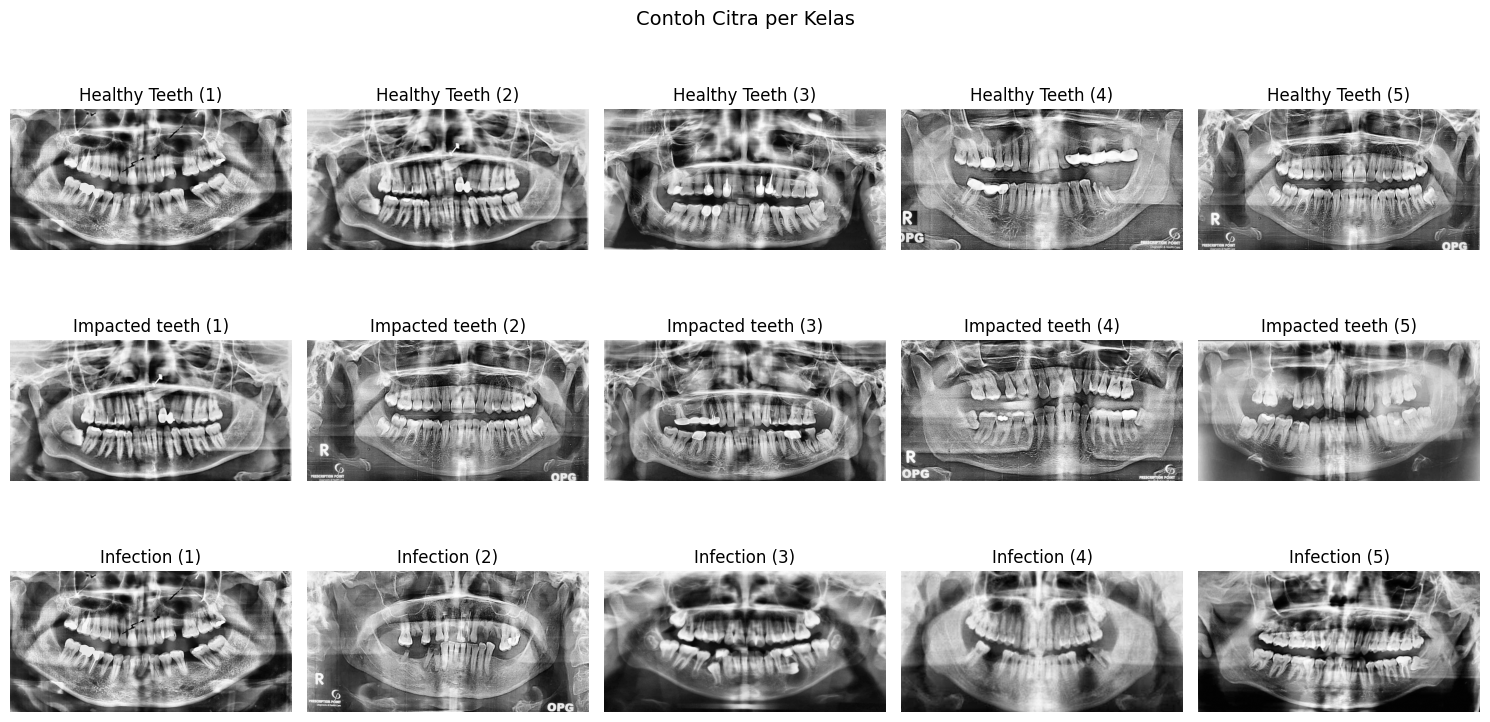

In [69]:
#Sample Gambar per Kelas
unique_labels = np.unique(labels)
plt.figure(figsize=(15, 8))  # disesuaikan agar muat 5 kolom

for i, label in enumerate(unique_labels):
    idxs = np.where(labels == label)[0][:5]  # ambil 5 indeks pertama untuk label ini
    for j, idx in enumerate(idxs):
        plt.subplot(len(unique_labels), 5, i*5 + j + 1)
        plt.imshow(data[idx], cmap='gray')
        plt.title(f"{label} ({j+1})")
        plt.axis('off')

plt.suptitle("Contoh Citra per Kelas", fontsize=14)
plt.tight_layout()
plt.show()

## Data Augmentation

### Define Augmentation Function


In [ ]:
# melakukan augmentasi data
data_augmented = []
labels_augmented = []
paths_augmented = []
file_name_augmented = []
for i in range(len(data)):
	pass

In [ ]:
print("Data sebelum augmentasi: ", len(data))
print("Data setelah augmentasi: ", len(data_augmented))

## Data Preparation

### Define Preprocessing Function


In [16]:
Sx = np.array([ [-1,0,1],
                [-2,0,2],
                [-1,0,1]])

Sy = np.array([ [1,2,1],
                [0,0,0],
                [-1,-2,-1]])

Px = np.array([ [-1,0,1],
                [-1,0,1],
                [-1,0,1]])

Py = np.array([ [1,1,1],
                [0,0,0],
                [-1,-1,-1]])

Rt = np.array([ [1,0],
                [0,-1]])

Rk = np.array([ [0,1],
                [-1,0]])

In [36]:
def padding_baris(image):
    height, width = image.shape
    img_pad = np.zeros((height, width+1))
    for i in range(height):
        for j in range(width):
            img_pad[i][j] = image[i][j]
    return img_pad

def padding_kolom(image):
    height, width = image.shape
    img_pad = np.zeros((height+1, width))
    for i in range(height):
        for j in range(width):
            img_pad[i][j] = image[i][j]
    return img_pad

def convo_edge(image, kernel, jenis):
    img_height, img_width = image.shape
    kernel_height, kernel_width = kernel.shape
    pad_height = kernel_height //2
    pad_width = kernel_width //2
    if(jenis!="roberts"):
        padded_img =  np.pad(image, ((pad_height, pad_height), (pad_width, pad_width)), mode='constant')
    else:
        padded_baris = padding_baris(image)
        padded_img = padding_kolom(padded_baris)
    result = np.zeros([img_height, img_width])

    for i in range(img_height):
        for j in range(img_width):
            result[i, j] = np.sum(padded_img[i:i+kernel_height, j:j+kernel_width] * kernel)
    return result

def deteksi_tepi(image, kernelX, kernelY, jenis):
    hasilX = convo_edge(image, kernelX, jenis)
    hasilY = convo_edge(image, kernelY, jenis)

    hasil = np.sqrt((hasilX*hasilX)+(hasilY*hasilY))

    return hasil

def thresholding(image, batas):
    hasil = np.copy(image)
    hasil[hasil>=batas] = 255
    hasil[hasil<batas] = 0

    for i in range(hasil.shape[0]):
        for j in range(hasil.shape[1]):
            if(hasil[i][j]==0):
                hasil[i][j]=255
            else:
                hasil[i][j]=0
    return hasil

### Preprocessing

In [29]:
sobel = deteksi_tepi(data[223], Sx, Sy, "sobel")
prewitt = deteksi_tepi(data[223], Px, Py, "prewitt")
robert = deteksi_tepi(data[223], Rt, Rk, "roberts")
thresh = thresholding(data[223], 200)

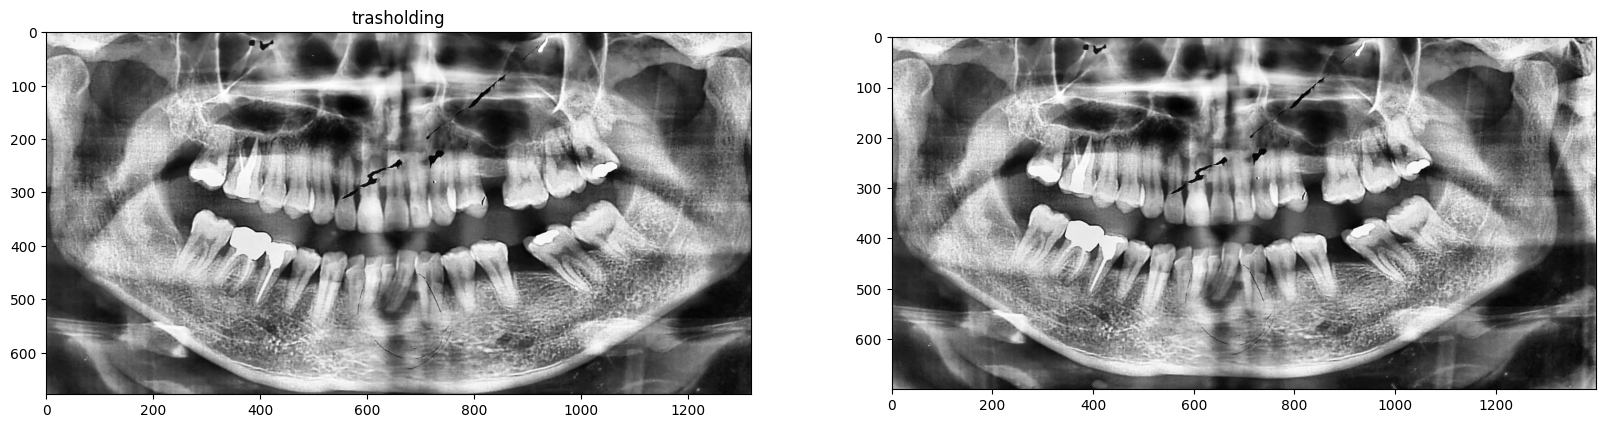

In [ ]:
import cv2 as cv

def preprocess_teeth(img):
    blur = cv.GaussianBlur(img, (5, 5), 0)
    _, thresh = cv.threshold(blur, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)
    kernel = np.ones((5, 5), np.uint8)
    closing = cv.morphologyEx(thresh, cv.MORPH_CLOSE, kernel)

    contours, _ = cv.findContours(closing, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    if contours:
        c = max(contours, key=cv.contourArea)
        x, y, w, h = cv.boundingRect(c)
        cropped = img[y:y+h, x:x+w]
    else:
        cropped = img

    normalized = cropped / 255.0
    return normalized

a = preprocess_teeth(data[0])

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.imshow(a, cmap='gray')
plt.title('trasholding')
plt.subplot(1, 2, 2)
plt.imshow(data[0], cmap='gray')

Text(0.5, 1.0, 'Impacted teeth')

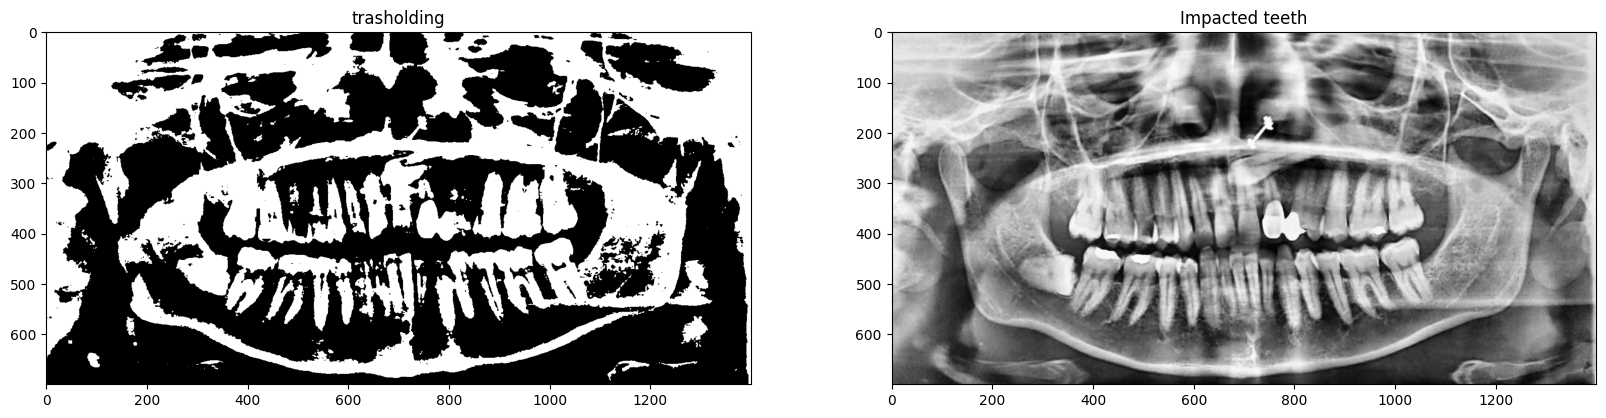

In [ ]:
# def thresholding(image, batas):
#     hasil = np.copy(image)
#     hasil[hasil>=batas] = 255
#     hasil[hasil<batas] = 0

#     for i in range(hasil.shape[0]):
#         for j in range(hasil.shape[1]):
#             if(hasil[i][j]==0):
#                 hasil[i][j]=0
#             else:
#                 hasil[i][j]=255
#     return hasil

# thresh = thresholding(data[223], 150)

# plt.figure(figsize=(20, 10))
# plt.subplot(1, 2, 1)
# plt.imshow(thresh, cmap='gray')
# plt.title('trasholding')
# plt.subplot(1, 2, 2)
# plt.imshow(data[223], cmap='gray')
# plt.title(labels[223])

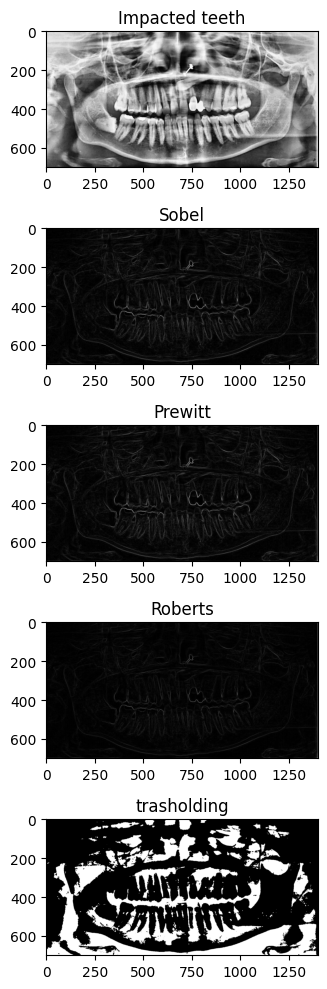

In [40]:
plt.figure(figsize=(20,10))
plt.subplot(5,1,1)
plt.imshow(data[223], cmap='gray')
plt.title(labels[223] )
plt.subplot(5,1,2)
plt.imshow(sobel, cmap='gray')
plt.title('Sobel')
plt.subplot(5,1,3)
plt.imshow(prewitt, cmap='gray')
plt.title('Prewitt')
plt.subplot(5,1,4)
plt.imshow(robert, cmap='gray')
plt.title('Roberts')
plt.subplot(5,1,5)
plt.imshow(thresh, cmap='gray')
plt.title('trasholding')

plt.tight_layout()
plt.show()

In [71]:
dataPreprocessed = [] 
for i in range(len(data)): 
	img = data[i] 
	img = thresholding(img, 150) 

	dataPreprocessed.append(img) 

dataPreprocessed = np.array(dataPreprocessed) 

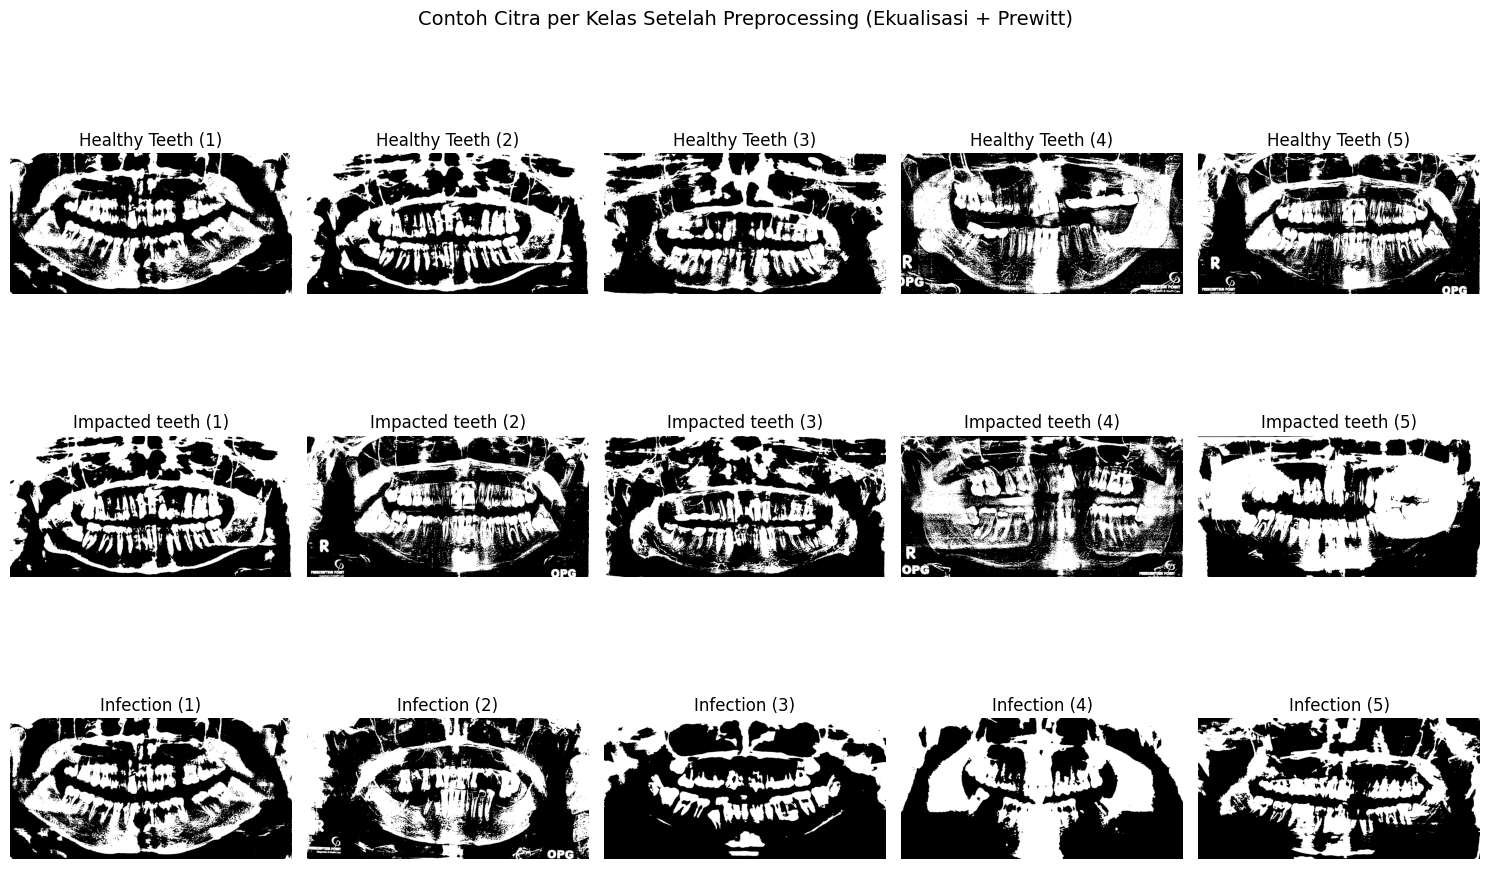

In [72]:
# 3. Menampilkan Sample Gambar per Kelas
unique_labels = np.unique(labels)
plt.figure(figsize=(15, 10))  # disesuaikan agar muat 5 kolom

for i, label in enumerate(unique_labels):
    idxs = np.where(labels == label)[0][:5]  # ambil 5 indeks pertama untuk label ini
    for j, idx in enumerate(idxs):
        plt.subplot(len(unique_labels), 5, i*5 + j + 1)
        plt.imshow(dataPreprocessed[idx], cmap='gray')
        plt.title(f"{label} ({j+1})")
        plt.axis('off')

plt.suptitle("Contoh Citra per Kelas Setelah Preprocessing (Ekualisasi + Prewitt)", fontsize=14)
plt.tight_layout()
plt.show()

### Feature Extraction

In [73]:
def glcm(image, derajat):
    if derajat == 0:
        angles = [0]
    elif derajat == 45:
        angles = [np.pi / 4]
    elif derajat == 90:
        angles = [np.pi / 2]
    elif derajat == 135:
        angles = [3 * np.pi / 4]
    else:
        raise ValueError("Invalid angle. It should be one of the following: 0, 45, 90, 135.")
    
    # mengembalikan matrix glcm dari image
    glcm = graycomatrix(image, [1], angles, 256, symmetric=True, normed=True)
    return glcm

In [74]:
def correlation(matriks):
	return graycoprops(matriks, 'correlation')[0, 0]

In [75]:
def dissimilarity(matriks):
    return graycoprops(matriks, 'dissimilarity')[0, 0]

In [76]:
def homogenity(matriks):
    return graycoprops(matriks, 'homogeneity')[0, 0]

In [77]:
def contrast(matriks):
    return graycoprops(matriks, 'contrast')[0, 0]

In [78]:
def ASM(matriks):
    return graycoprops(matriks, 'ASM')[0, 0]

In [79]:
def energy(matriks):
    return graycoprops(matriks, 'energy')[0, 0]

In [80]:
def entropyGlcm(matriks):
    return entropy(matriks.ravel())

In [81]:
Derajat0 = []
Derajat45 = []
Derajat90 = []
Derajat135 = []
for i in range(len(dataPreprocessed)):
    D0 = glcm(dataPreprocessed[i], 0)
    D45 = glcm(dataPreprocessed[i], 45)
    D90 = glcm(dataPreprocessed[i], 90)
    D135 = glcm(dataPreprocessed[i], 135)
    Derajat0.append(D0)
    Derajat45.append(D45)
    Derajat90.append(D90)
    Derajat135.append(D135)

In [82]:
Kontras0, Kontras45, Kontras90, Kontras135 = [], [], [], []
dissimilarity0, dissimilarity45, dissimilarity90, dissimilarity135 =  [], [], [], []
homogenity0, homogenity45, homogenity90, homogenity135 = [], [], [], []
entropy0, entropy45, entropy90, entropy135 =  [], [], [], []
ASM0, ASM45, ASM90, ASM135 =  [], [], [], []
energy0, energy45, energy90, energy135 =  [], [], [], []
correlation0, correlation45, correlation90, correlation135 = [], [], [], []


In [83]:
for i in range(len(dataPreprocessed)):
    C0 = correlation(Derajat0[i])
    correlation0.append(C0)
    C45 = correlation(Derajat45[i])
    correlation45.append(C45)
    C90 = correlation(Derajat90[i])
    correlation90.append(C90)
    C135 = correlation(Derajat135[i])
    correlation135.append(C135)

In [84]:
for i in range(len(data)):
    K0 = contrast(Derajat0[i])
    K45 = contrast(Derajat45[i])
    K90 = contrast(Derajat90[i])
    K135 = contrast(Derajat135[i])
    Kontras0.append(K0)
    Kontras45.append(K45)
    Kontras90.append(K90)
    Kontras135.append(K135)

In [85]:
for i in range(len(data)):
    Dis0 = dissimilarity(Derajat0[i])
    Dis45 = dissimilarity(Derajat45[i])
    Dis90 = dissimilarity(Derajat90[i])
    Dis135 = dissimilarity(Derajat135[i])
    dissimilarity0.append(Dis0)
    dissimilarity45.append(Dis45)
    dissimilarity90.append(Dis90)
    dissimilarity135.append(Dis135)

In [86]:
for i in range(len(data)):
    H0 = homogenity(Derajat0[i])
    H45 = homogenity(Derajat45[i])
    H90 = homogenity(Derajat90[i])
    H135 = homogenity(Derajat135[i])
    homogenity0.append(H0)
    homogenity45.append(H45)
    homogenity90.append(H90)
    homogenity135.append(H135)

In [87]:
for i in range(len(data)):  
    E0 = entropyGlcm(Derajat0[i])
    E45 = entropyGlcm(Derajat45[i])
    E90 = entropyGlcm(Derajat90[i])
    E135 = entropyGlcm(Derajat135[i])
    entropy0.append(E0)
    entropy45.append(E45)
    entropy90.append(E90)
    entropy135.append(E135)

In [88]:
for i in range(len(data)):
    A0 = ASM(Derajat0[i])
    A45 = ASM(Derajat45[i])
    A90 = ASM(Derajat90[i])
    A135 = ASM(Derajat135[i])
    ASM0.append(A0)
    ASM45.append(A45)
    ASM90.append(A90)
    ASM135.append(A135)

In [89]:
for i in range(len(data)):
    ER0 = energy(Derajat0[i])
    ER45 = energy(Derajat45[i])
    ER90 = energy(Derajat90[i])
    ER135 = energy(Derajat135[i])
    energy0.append(ER0)
    energy45.append(ER45)
    energy90.append(ER90)
    energy135.append(ER135)

### Write the extraction's results to CSV 

In [90]:
dataTable = {'Filename': file_name, 'Label': labels,
        'Contrast0': Kontras0, 'Contrast45': Kontras45, 'Contrast90': Kontras90, 'Contrast135': Kontras135,
        'Homogeneity0': homogenity0, 'Homogeneity45': homogenity45, 'Homogeneity90': homogenity90, 'Homogeneity135': homogenity135,
        'Dissimilarity0': dissimilarity0, 'Dissimilarity45': dissimilarity45, 'Dissimilarity90': dissimilarity90, 'Dissimilarity135': dissimilarity135,
        'Entropy0': entropy0, 'Entropy45': entropy45, 'Entropy90': entropy90, 'Entropy135': entropy135,
        'ASM0': ASM0, 'ASM45': ASM45, 'ASM90': ASM90, 'ASM135': ASM135,
        'Energy0': energy0, 'Energy45': energy45, 'Energy90': energy90, 'Energy135': energy135,
        'Correlation0': correlation0, 'Correlation45': correlation45, 'Correlation90': correlation90, 'Correlation135': correlation135,
        }
df = pd.DataFrame(dataTable)
df.to_csv('hasil_ekstraksi_1.csv', index=False)

hasilEkstrak = pd.read_csv('hasil_ekstraksi_1.csv')
hasilEkstrak


,Filename,Label,Contrast0,Contrast45,Contrast90,Contrast135,Homogeneity0,Homogeneity45,Homogeneity90,Homogeneity135,...,ASM90,ASM135,Energy0,Energy45,Energy90,Energy135,Correlation0,Correlation45,Correlation90,Correlation135
0,1.jpg,Healthy Teeth,2287.594506,3314.948369,2420.131361,3292.938702,0.964820,0.949021,0.962782,0.949360,...,0.488694,0.476474,0.700499,0.690050,0.699066,0.690271,0.925992,0.892776,0.921723,0.893488
1,10.jpg,Healthy Teeth,1548.302818,2285.148650,1616.920448,2297.317136,0.976189,0.964858,0.975134,0.964671,...,0.479455,0.469683,0.693198,0.685461,0.692427,0.685335,0.952017,0.929182,0.949897,0.928804
2,100.jpg,Healthy Teeth,1882.756944,2859.660794,2127.366033,2842.438728,0.971046,0.956023,0.967284,0.956288,...,0.484545,0.474508,0.698747,0.688670,0.696093,0.688845,0.940132,0.909078,0.932378,0.909626
3,101.jpg,Healthy Teeth,3770.626647,5409.457399,4084.096260,5460.458651,0.942014,0.916811,0.937193,0.916027,...,0.446601,0.428487,0.671468,0.655088,0.668282,0.654589,0.882737,0.831799,0.872996,0.830213
4,102.jpg,Healthy Teeth,3195.607245,4426.336792,3103.206162,4359.509858,0.950856,0.931930,0.952277,0.932957,...,0.489391,0.472395,0.698722,0.686663,0.699565,0.687310,0.894327,0.853628,0.897405,0.855838
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
328,77.jpg,Infection,2686.788114,3882.944056,2743.860975,3858.474094,0.958681,0.940286,0.957804,0.940663,...,0.474567,0.459088,0.689422,0.677316,0.688888,0.677561,0.914821,0.876901,0.912999,0.877677
329,8.jpg,Infection,1485.621720,2339.075658,1784.101012,2358.691524,0.977153,0.964029,0.972563,0.963727,...,0.478667,0.470362,0.695019,0.686034,0.691857,0.685830,0.953809,0.927282,0.944532,0.926673
330,84.jpg,Infection,2197.888824,3264.878040,2377.738197,3267.537818,0.966200,0.949791,0.963434,0.949750,...,0.469925,0.457428,0.687397,0.676362,0.685511,0.676335,0.931692,0.898535,0.926105,0.898452
331,85.jpg,Infection,3523.487823,4698.365632,3269.855150,4683.071906,0.945814,0.927746,0.949715,0.927982,...,0.543011,0.523990,0.734614,0.723733,0.736893,0.723872,0.867544,0.823414,0.877121,0.823989


### Features Selection

pada bagian seleksi fitur ini bisa menggunakan metode seperti
- PCA
- LDA
- t-SNE
- Chi-square
- ANOVA
- Autoencoder
- correlation
- dll

berikut contoh menggunakan correlation:

<Axes: >

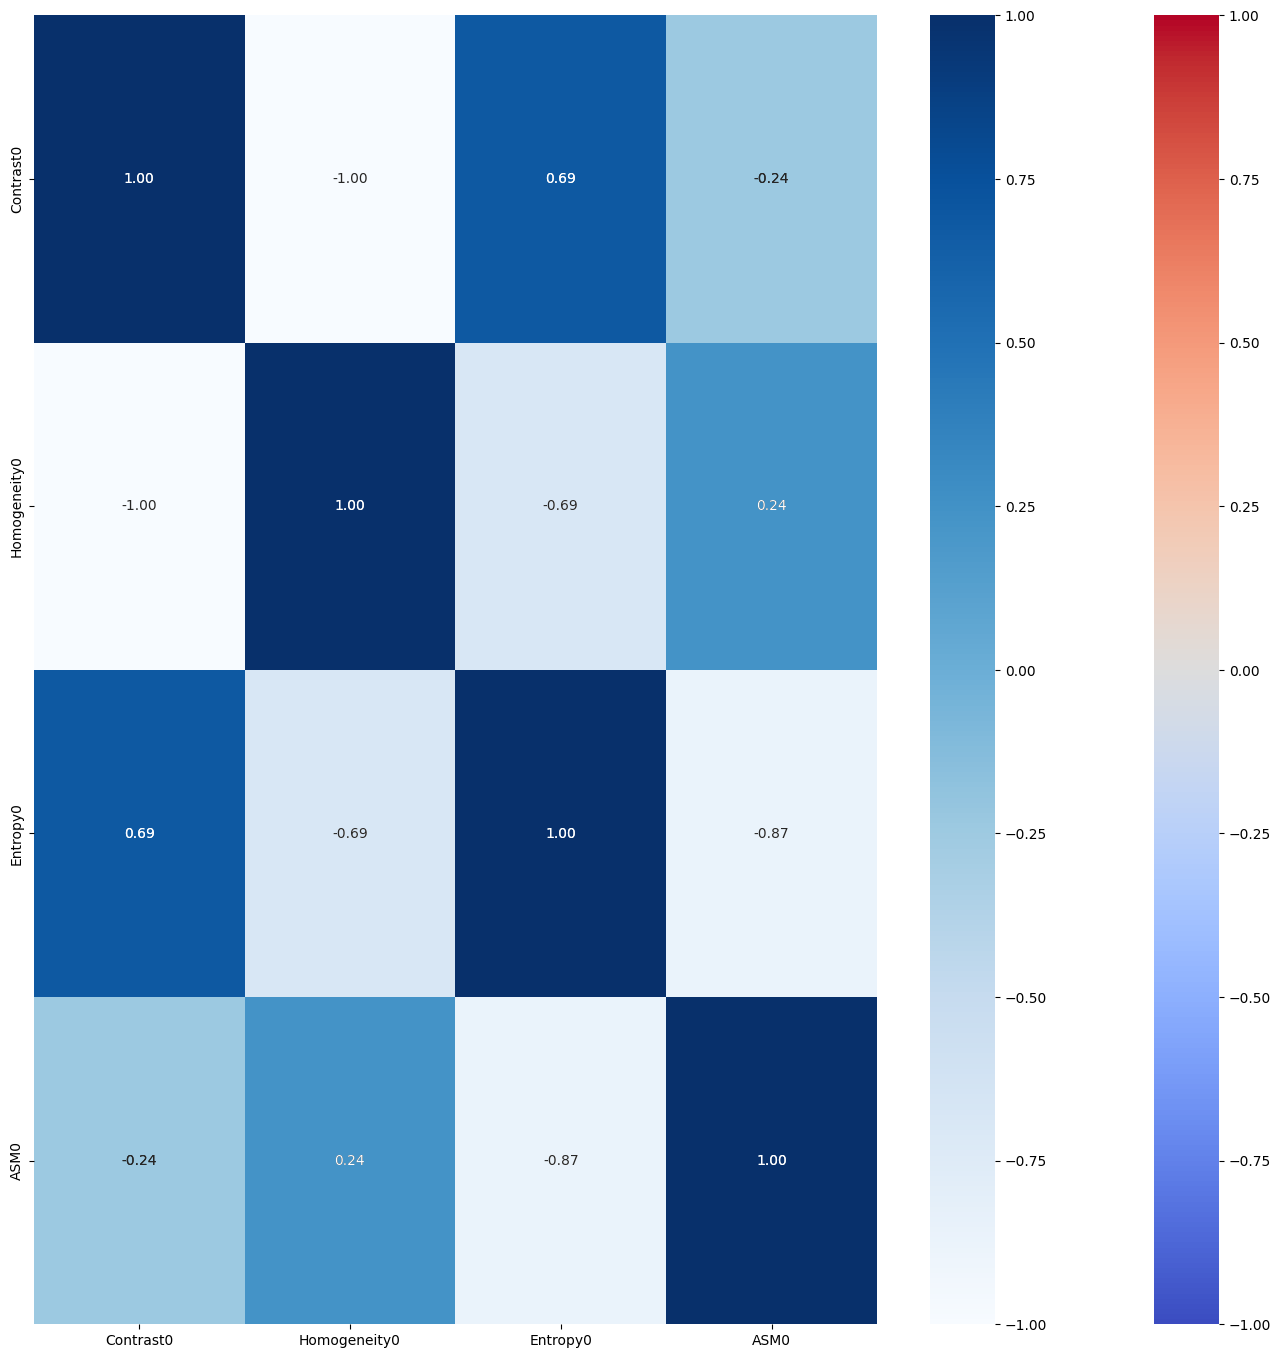

In [ ]:
# Menghitung korelasi
correlation = hasilEkstrak.drop(columns=['Label','Filename']).corr()

# Menyaring fitur yang memiliki korelasi absolut lebih dari 0.95 dengan label
threshold = 0.95 # atur threshold ini untuk menentukan seberapa besar korelasi yang ingin disaring
selectionFeature = []
columns = np.full((correlation.shape[0],), True, dtype=bool)
for i in range(correlation.shape[0]):
	for j in range(i+1, correlation.shape[0]):
		if correlation.iloc[i,j] >= threshold:
			if columns[j]:
				columns[j] = False
select = hasilEkstrak.drop(columns=['Label','Filename']).columns[columns]
x_new = hasilEkstrak[select]
x_new
y = hasilEkstrak['Label']
plt.figure(figsize=(17,17))
sns.heatmap(x_new.corr(), annot=True, cmap='coolwarm', fmt=".2f")
# sns.heatmap(x_new.corr(), annot=True, cmap='Blues', fmt=".2f")

## Splitting Data

In [92]:
# ubah bagian test_size sesuai kebutuhan
# 0.3 = 30% data untuk testing (train/test 70/30)
# 0.2 = 20% data untuk testing (train/test 80/20)
X_train, X_test, y_train, y_test = train_test_split(x_new, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)

(266, 4)
(67, 4)


## Feature Normalization

berikut metode normalisasi yang bisa digunakan:
- Min-Max Scaling
- Standardization (Z-score)
- Robust Scaling
- MaxAbsScaler
- dll

berikut contoh menggunakan Standardization (Z-score):

In [93]:
# normalisasi mean std
X_test = (X_test - X_train.mean()) / X_train.std()
X_train = (X_train - X_train.mean()) / X_train.std()

## Modeling

### Define Model

In [94]:
def generateClassificationReport(y_true, y_pred):
	print(classification_report(y_true, y_pred))
	print(confusion_matrix(y_true, y_pred))
	print('Accuracy:', accuracy_score(y_true, y_pred))

# Define classifiers
rf = RandomForestClassifier(n_estimators=5, random_state=42)
svm = SVC(kernel='rbf', random_state=42)
knn = KNeighborsClassifier(n_neighbors=5)

### Train Random Forest Classifier

In [95]:
# Train Random Forest Classifier
rf.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("------Training Set------")
y_pred = rf.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = rf.predict(X_test)
generateClassificationReport( y_test, y_pred)

------Training Set------
                precision    recall  f1-score   support

 Healthy Teeth       0.80      0.83      0.81       178
Impacted teeth       0.57      0.56      0.56        72
     Infection       0.60      0.38      0.46        16

      accuracy                           0.73       266
     macro avg       0.66      0.59      0.61       266
  weighted avg       0.72      0.73      0.72       266

[[148  27   3]
 [ 31  40   1]
 [  7   3   6]]
Accuracy: 0.7293233082706767

------Testing Set------
                precision    recall  f1-score   support

 Healthy Teeth       0.53      0.51      0.52        45
Impacted teeth       0.05      0.07      0.06        15
     Infection       0.00      0.00      0.00         7

      accuracy                           0.36        67
     macro avg       0.19      0.19      0.19        67
  weighted avg       0.37      0.36      0.36        67

[[23 19  3]
 [13  1  1]
 [ 7  0  0]]
Accuracy: 0.3582089552238806


### Train SVM Classifier

In [96]:
# Train SVM Classifier
svm.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred = svm.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = svm.predict(X_test)
generateClassificationReport( y_test, y_pred)


------Training Set------
                precision    recall  f1-score   support

 Healthy Teeth       0.67      1.00      0.80       178
Impacted teeth       1.00      0.01      0.03        72
     Infection       0.00      0.00      0.00        16

      accuracy                           0.67       266
     macro avg       0.56      0.34      0.28       266
  weighted avg       0.72      0.67      0.55       266

[[178   0   0]
 [ 71   1   0]
 [ 16   0   0]]
Accuracy: 0.6729323308270677

------Testing Set------
                precision    recall  f1-score   support

 Healthy Teeth       0.67      1.00      0.80        45
Impacted teeth       0.00      0.00      0.00        15
     Infection       0.00      0.00      0.00         7

      accuracy                           0.67        67
     macro avg       0.22      0.33      0.27        67
  weighted avg       0.45      0.67      0.54        67

[[45  0  0]
 [15  0  0]
 [ 7  0  0]]
Accuracy: 0.6716417910447762


C:\Users\yoga7.RAKASYA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\yoga7.RAKASYA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\yoga7.RAKASYA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklea

### Train KNN Classifier

In [97]:
# Train KNN Classifier
knn.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred = knn.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = knn.predict(X_test)
generateClassificationReport( y_test, y_pred)



------Training Set------
                precision    recall  f1-score   support

 Healthy Teeth       0.69      0.96      0.80       178
Impacted teeth       0.63      0.17      0.26        72
     Infection       0.00      0.00      0.00        16

      accuracy                           0.69       266
     macro avg       0.44      0.38      0.36       266
  weighted avg       0.63      0.69      0.61       266

[[171   7   0]
 [ 60  12   0]
 [ 16   0   0]]
Accuracy: 0.6879699248120301

------Testing Set------
                precision    recall  f1-score   support

 Healthy Teeth       0.64      0.87      0.74        45
Impacted teeth       0.00      0.00      0.00        15
     Infection       0.00      0.00      0.00         7

      accuracy                           0.58        67
     macro avg       0.21      0.29      0.25        67
  weighted avg       0.43      0.58      0.49        67

[[39  6  0]
 [15  0  0]
 [ 7  0  0]]
Accuracy: 0.582089552238806


C:\Users\yoga7.RAKASYA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\yoga7.RAKASYA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\yoga7.RAKASYA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklea

## Evaluation With Confusion Matrix

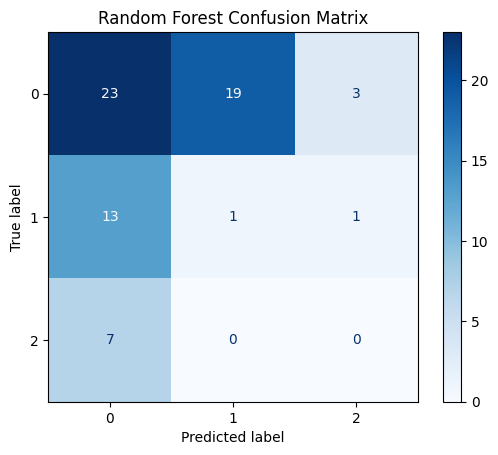

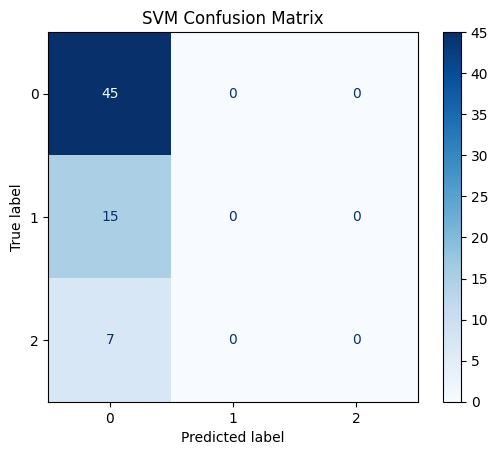

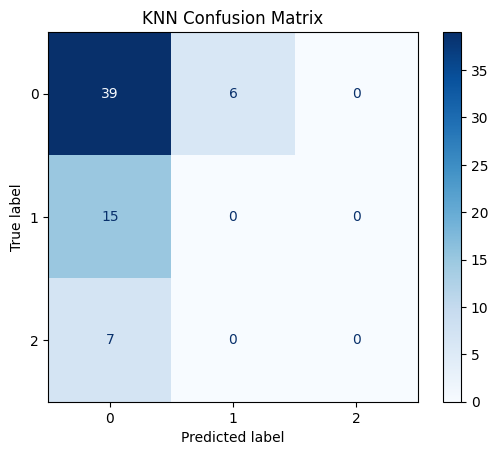

In [103]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()

# Plot confusion matrix for Random Forest
plot_confusion_matrix(y_test, rf.predict(X_test), "Random Forest Confusion Matrix")
# Plot confusion matrix for SVM
plot_confusion_matrix(y_test, svm.predict(X_test), "SVM Confusion Matrix")
# Plot confusion matrix for KNN
plot_confusion_matrix(y_test, knn.predict(X_test), "KNN Confusion Matrix")